MSc Thesis Topic: **Real Time Uncertainty Estimation for detecting anomalies in Industrial control system.**

Author : Ayyoub Soullami

Supervisor : Ermiyas Ph.D.

>  This study explores the use of real-time uncertainty estimation techniques to enhance the detection of anomalies within these systems.







# **1.   Setup**



In [ ]:
!pip install scikeras

In [ ]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninst

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, BatchNormalization, LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer,r2_score
from sklearn.metrics import mean_squared_error
from keras.models import clone_model
from tensorflow.keras.models import Model, Sequential
# from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Setting visualization style
sns.set_style('whitegrid')


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/




# **2.   Data Loading**



In [ ]:
SWaT_normal_path = '/content/drive/My Drive/swat/SWaT_Dataset_Normal_v0.csv'
SWaT_attack_path = '/content/drive/My Drive/swat/SWaT_Dataset_Attack_v0.csv'

In [ ]:
# SWaT_normal_path = '/content/drive/My Drive/datasets/SWaT_Dataset_Normal_v0.csv'
# SWaT_attack_path = '/content/drive/My Drive/datasets/SWaT_Dataset_Attack_v0.csv'

In [ ]:
SWaT_normal = pd.read_csv(SWaT_normal_path)
SWaT_attack = pd.read_csv(SWaT_attack_path)

In [ ]:
# combine both datasets
ds = pd.concat([SWaT_normal, SWaT_attack])

In [ ]:
# Converting the Timestamp to a datetime and set it as an index
ds['Timestamp'] = pd.to_datetime(ds['Timestamp'])
ds= ds.set_index('Timestamp')

<ipython-input-51-0fd2da0bd827>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
# display first 5 rows of the dataset

ds.head(3)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2015-12-22 16:00:01,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2015-12-22 16:00:02,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


> The dataset consists of several features, most of which appear to be numerical, representing various measurements and states from the water treatment process.

**Features:**

> Timestamp: The date and time when the measurements were taken.
FIT101, LIT101, ... FIT601: Various sensor readings, related to flow rates (FIT), level indicators (LIT), and other process measurements. The prefixes (e.g., FIT, LIT, AIT, PIT) suggest different types of sensors or measurements, while the numbers indicate specific points or sensors within the system.
MV101, P101, P102, ... P603: These appear to be state indicators for various equipment pieces (e.g., motor valves (MV), pumps (P)). The values are binary (e.g., 1 for on/running, 2 or 0 for off/stopped).

**Target Variable:**

> Normal/Attack: This column indicates whether the measurements at a given timestamp are from a normal operation period or during an attack (cyber-physical or otherwise). This is a categorical variable with at least two categories: Normal and Attack.





# **3. Data Preprocessing and Cleaning**




In [ ]:
# Check for missing values in the dataset
missing_values = ds.isnull().sum()

# Count the number of missing values in each column
missing_values_count = missing_values[missing_values > 0]

print(missing_values_count)

Series([], dtype: int64)


> The dataset does not contain any missing values, so we don't need to handle missing data through imputation or dropping rows/columns.


In [ ]:
attack_values = ds['Normal/Attack'].unique()

attack_values

array(['Normal', 'Attack', 'A ttack'], dtype=object)

In [ ]:
# Remove extra spaces
ds['Normal/Attack'] = ds['Normal/Attack'].str.replace(' ', '')

> For the sake of simplicity, we will rename the 'Normal/Attack' column to  'status'

In [ ]:
ds.rename(columns={'Normal/Attack': 'status'}, inplace=True)

> The 'status' column needs to be converted into a numeric format for modeling. we will use label encoding, where "Normal" will be encoded as 0 and "Attack" as 1.

In [ ]:
ds['status'] = ds['status'].map({'Normal': 0, 'Attack': 1})


In [ ]:
ds.head(1)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,status
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0


# **Apply SMOTE-NC**


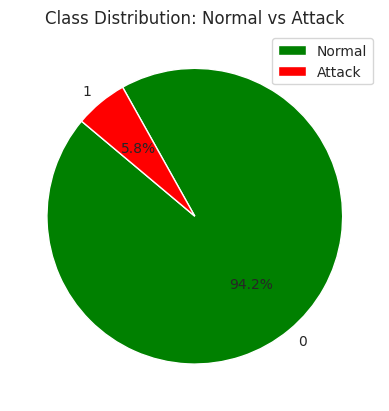

In [ ]:
# Count the number of occurrences of each class in the target series
class_distribution = ds['status'].value_counts()

# Plotting the class distribution as a pie chart
fig, ax = plt.subplots()
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['green', 'red'], ax=ax)

plt.title('Class Distribution: Normal vs Attack')
plt.ylabel('')  # Hide the y-label as it's not needed in pie charts

# Replace the numerical labels with the actual class names
class_labels = ['Normal' if x == 0 else 'Attack' for x in class_distribution.index]

plt.legend(labels=class_labels)

plt.show()

In [ ]:
target = ds['status']
target = target.reset_index(drop=True)

ds = ds.drop('status', axis=1)

In [ ]:
ds.head(1)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,2,...,0.0,1,1,10.02948,0.0,4.277749,0.000256,1,1,1


In [ ]:
target.head(1)

0    0
Name: status, dtype: int64

>Identifying and removing constant features is an important step in data preprocessing, as these features provide no variability and therefore no useful information to a model. A constant feature is one that has the same value across all observations in the dataset.

In [ ]:
# Identify constant features based on standard deviation
constant_features_std = [col for col in ds.columns if ds[col].std() == 0]

print("Constant features based on standard deviation:", constant_features_std)

Constant features based on standard deviation: ['P202', 'P401', 'P404', 'P502', 'P601', 'P603']


In [ ]:
# Remove constant features from the DataFrame
ds = ds.drop(columns=constant_features_std)

In [ ]:
# Using list comprehensions to classify numerical and categorical features
numerical_features = [column for column in ds.columns if ds[column].nunique() > 10]
categorical_features = [column for column in ds.columns if ds[column].nunique() <= 10]
print(len(numerical_features), 'Numerical Features :', numerical_features, len(categorical_features), 'Categorical Features :', categorical_features)

25 Numerical Features : ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601'] 20 Categorical Features : ['MV101', 'P101', 'P102', 'MV201', 'P201', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'P403', 'UV401', 'P501', 'P602']


In [ ]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
from imblearn.over_sampling import SMOTENC

In [ ]:
# Convert column names to indices
categorical_features_indices = [ds.columns.get_loc(name) for name in categorical_features]

# Use the indices for SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)

# Fit and resample the dataset
X_resampled, y_resampled = smote_nc.fit_resample(ds, target)

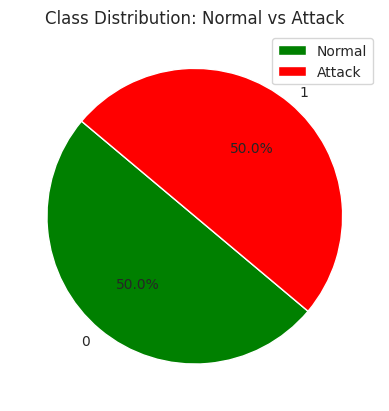

In [ ]:
# Count the number of occurrences of each class in the target series
class_distribution = y_resampled.value_counts()

# Plotting the class distribution as a pie chart
fig, ax = plt.subplots()
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['green', 'red'], ax=ax)

plt.title('Class Distribution: Normal vs Attack')
plt.ylabel('')

# Replace the numerical labels with the actual class names
class_labels = ['Normal' if x == 0 else 'Attack' for x in class_distribution.index]

plt.legend(labels=class_labels)

plt.show()

In [ ]:
num_features = ds[numerical_features]
cat_features = ds[categorical_features]

# Min-Max scaling for numerical features
scaler = MinMaxScaler()
numerical_data_scaled = scaler.fit_transform(num_features)
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=num_features.columns)

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(cat_features)

categorical_feature_names = encoder.get_feature_names_out(cat_features.columns)
categorical_data_encoded = encoder.transform(cat_features)
categorical_data_encoded_df = pd.DataFrame(categorical_data_encoded, columns=categorical_feature_names)
preprocessed_ds = pd.concat([numerical_data_scaled_df, categorical_data_encoded_df], axis=1)

In [ ]:
preprocessed_ds.info()
preprocessed_ds.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946719 entries, 0 to 946718
Data columns (total 51 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   FIT101   946719 non-null  float64
 1   LIT101   946719 non-null  float64
 2   AIT201   946719 non-null  float64
 3   AIT202   946719 non-null  float64
 4   AIT203   946719 non-null  float64
 5   FIT201   946719 non-null  float64
 6   DPIT301  946719 non-null  float64
 7   FIT301   946719 non-null  float64
 8   LIT301   946719 non-null  float64
 9   AIT401   946719 non-null  float64
 10  AIT402   946719 non-null  float64
 11  FIT401   946719 non-null  float64
 12  LIT401   946719 non-null  float64
 13  AIT501   946719 non-null  float64
 14  AIT502   946719 non-null  float64
 15  AIT503   946719 non-null  float64
 16  AIT504   946719 non-null  float64
 17  FIT501   946719 non-null  float64
 18  FIT502   946719 non-null  float64
 19  FIT503   946719 non-null  float64
 20  FIT504   946719 non-null  

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV303_2,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2
0,0.894987,0.160292,0.730144,0.732892,0.073596,0.874201,0.462186,0.940694,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.890230,0.159845,0.730144,0.732892,0.073596,0.873249,0.462186,0.940371,0.182199,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
preprocessed_ds['label'] = y_resampled

In [ ]:
preprocessed_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1784196 entries, 0 to 1784195
Data columns (total 52 columns):
 #   Column   Dtype  
---  ------   -----  
 0   FIT101   float64
 1   LIT101   float64
 2   AIT201   float64
 3   AIT202   float64
 4   AIT203   float64
 5   FIT201   float64
 6   DPIT301  float64
 7   FIT301   float64
 8   LIT301   float64
 9   AIT401   float64
 10  AIT402   float64
 11  FIT401   float64
 12  LIT401   float64
 13  AIT501   float64
 14  AIT502   float64
 15  AIT503   float64
 16  AIT504   float64
 17  FIT501   float64
 18  FIT502   float64
 19  FIT503   float64
 20  FIT504   float64
 21  PIT501   float64
 22  PIT502   float64
 23  PIT503   float64
 24  FIT601   float64
 25  MV101_1  float64
 26  MV101_2  float64
 27  P101_2   float64
 28  P102_2   float64
 29  MV201_1  float64
 30  MV201_2  float64
 31  P201_2   float64
 32  P203_2   float64
 33  P204_2   float64
 34  P205_2   float64
 35  P206_2   float64
 36  MV301_1  float64
 37  MV301_2  float64
 38  MV

# **4.   Exploratory Data Analysis (EDA)**

In [ ]:
summary_statistics = preprocessed_ds.describe()
print(summary_statistics)

             FIT101        LIT101        AIT201        AIT202        AIT203  \
count  1.784196e+06  1.784196e+06  1.784196e+06  1.784196e+06  1.784196e+06   
mean   4.770139e-01  6.106518e-01  5.106170e-01  8.357631e-01  1.794693e-01   
std    4.604386e-01  1.655737e-01  3.520065e-01  5.130591e-02  1.156427e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  4.484684e-01  2.106716e-01  7.986228e-01  1.221152e-01   
50%    8.778847e-01  6.176429e-01  2.900955e-01  8.455894e-01  1.604578e-01   
75%    9.238801e-01  7.875418e-01  8.945101e-01  8.699306e-01  1.994366e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             FIT201       DPIT301        FIT301        LIT301        AIT401  \
count  1.784196e+06  1.784196e+06  1.784196e+06  1.784196e+06  1.784196e+06   
mean   4.466192e-01  2.789213e-01  5.276102e-01  7.483714e-01  9.537610e-01   
std    4.365326e-01  2.135299e-01  4.574377e-01  9.

**4.1.   Distribution of the class label**


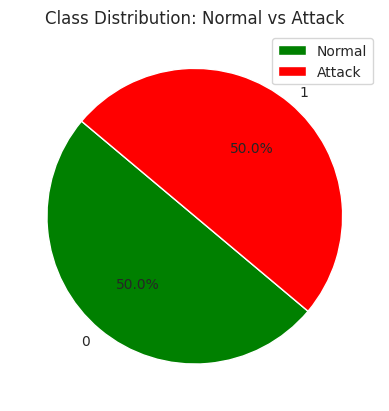

In [ ]:
# Count the number of occurrences of each class in the target series
class_distribution = y_resampled.value_counts()

# Plotting the class distribution as a pie chart
fig, ax = plt.subplots()
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['green', 'red'], ax=ax)

plt.title('Class Distribution: Normal vs Attack')
plt.ylabel('')  # Hide the y-label as it's not needed in pie charts

# Replace the numerical labels with the actual class names
class_labels = ['Normal' if x == 0 else 'Attack' for x in class_distribution.index]

plt.legend(labels=class_labels)

plt.show()




### 4.2 Correlation Analysis


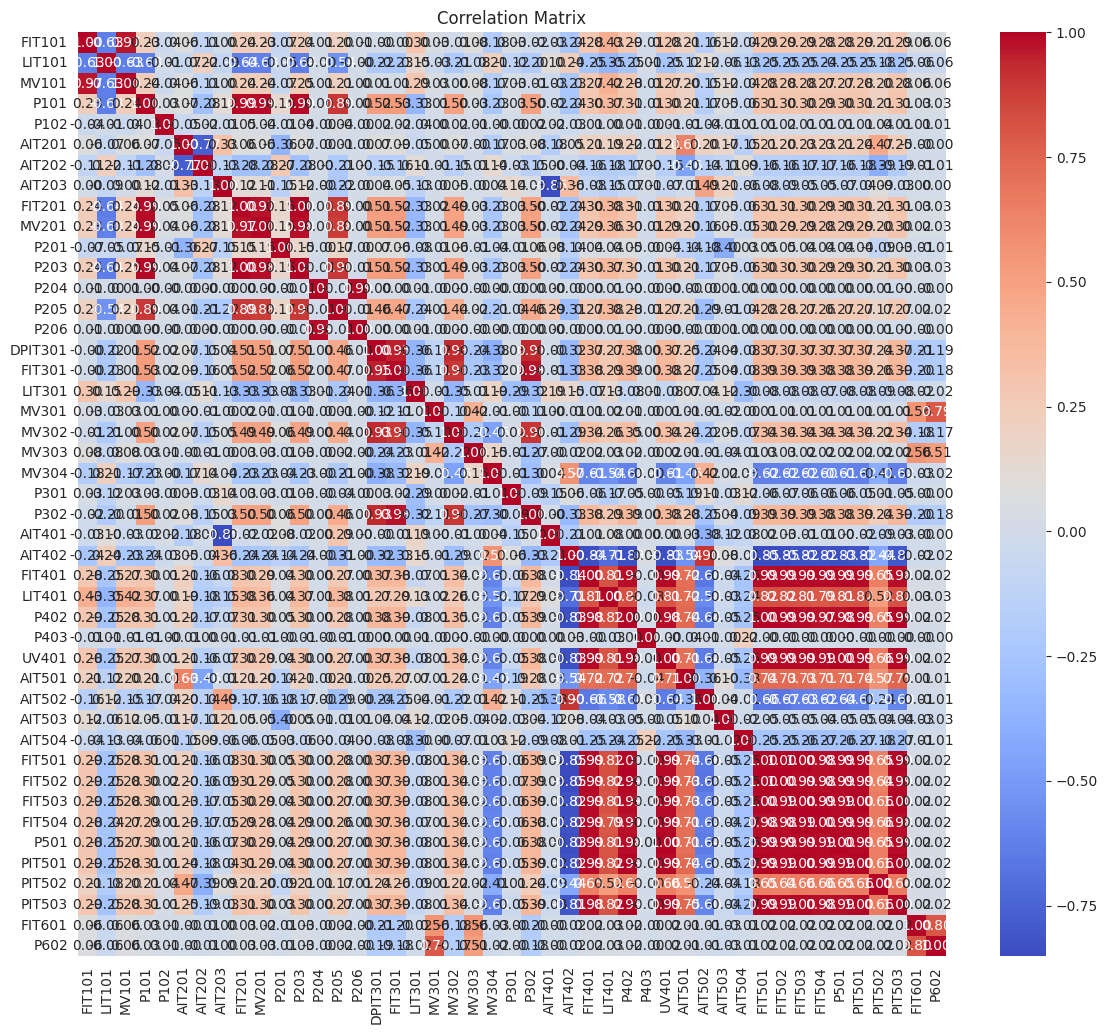

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(ds.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# 5. Model building

# AutoEncoder

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_ds, target, test_size=0.2, random_state=42)
X_train = X_train[y_train == 0]
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (713728, 52)
Test data shape: (189344, 52)


# **Baseline**

In [ ]:
def build_autoencoder(input_dim, hidden_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    hidden_layer = Dense(hidden_dim, activation='sigmoid')(input_layer)

    # Decoder
    output_layer = Dense(input_dim, activation='sigmoid')(hidden_layer)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

    return autoencoder

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Build and train the autoencoder
input_dim = X_train.shape[1]
hidden_dim = 8  # As specified in the paper
autoencoder = build_autoencoder(input_dim, hidden_dim)
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Save the model
#autoencoder.save('baseline_autoencoder.h5')

print("Model training completed and saved as 'baseline_autoencoder.h5'")


Epoch 1/50
17844/17844 [==============================] - 33s 2ms/step - loss: 0.0107 - val_loss: 0.0017
Epoch 2/50
17844/17844 [==============================] - 33s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/50
17844/17844 [==============================] - 31s 2ms/step - loss: 9.8656e-04 - val_loss: 9.0558e-04
Epoch 4/50
17844/17844 [==============================] - 31s 2ms/step - loss: 8.4151e-04 - val_loss: 7.9648e-04
Epoch 5/50
17844/17844 [==============================] - 33s 2ms/step - loss: 7.5849e-04 - val_loss: 7.3461e-04
Epoch 6/50
17844/17844 [==============================] - 32s 2ms/step - loss: 7.0550e-04 - val_loss: 6.9514e-04
Epoch 7/50
17844/17844 [==============================] - 34s 2ms/step - loss: 6.7008e-04 - val_loss: 6.6521e-04
Epoch 8/50
17844/17844 [==============================] - 33s 2ms/step - loss: 6.4444e-04 - val_loss: 6.3787e-04
Epoch 9/50
17844/17844 [==============================] - 33s 2ms/step - loss: 6.2416e-04 - val_loss: 6.2247e-04

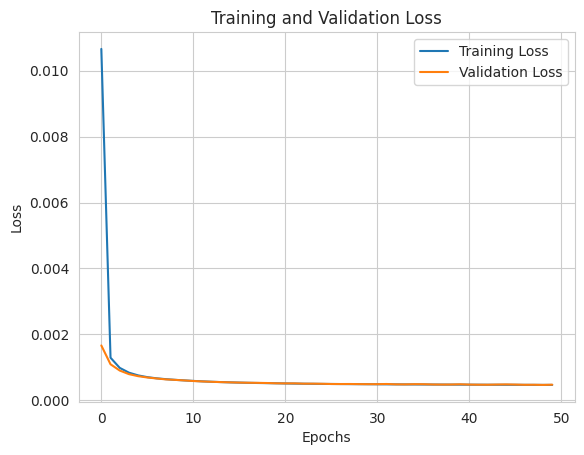

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

5917/5917 [==============================] - 7s 1ms/step


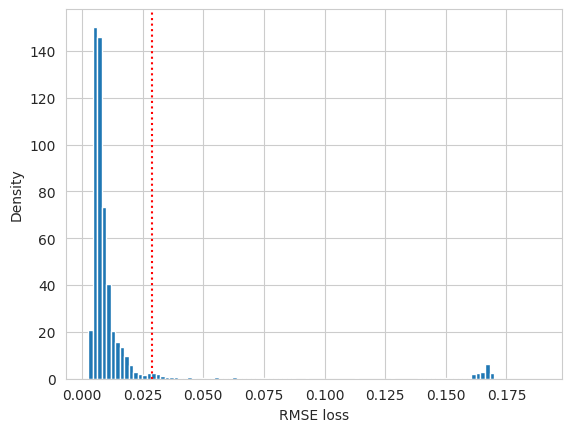

In [ ]:
X_test_predictions = autoencoder.predict(X_test)

mae = np.mean(np.abs(X_test_predictions - X_test), axis=1)
# Plot the histogram of RMSE loss
plt.hist(mae, bins=100, density=True)
plt.xlabel('RMSE loss')
plt.ylabel('Density')

# Visual determination of threshold - assuming you've determined it to be at RMSE = 0.25
# threshold = np.percentile(mae, 85)
threshold = 0.028855
plt.axvline(x=threshold, color='r', linestyle='dotted')

plt.show()

y_pred = (mae > threshold).astype(int)

In [ ]:
# Calculate the F1 Score, Precision, and Recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.9103436092218002
Precision: 0.8832704833733288
Recall: 0.9391288500091124


In [ ]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    178370
           1       0.88      0.94      0.91     10974

    accuracy                           0.99    189344
   macro avg       0.94      0.97      0.95    189344
weighted avg       0.99      0.99      0.99    189344



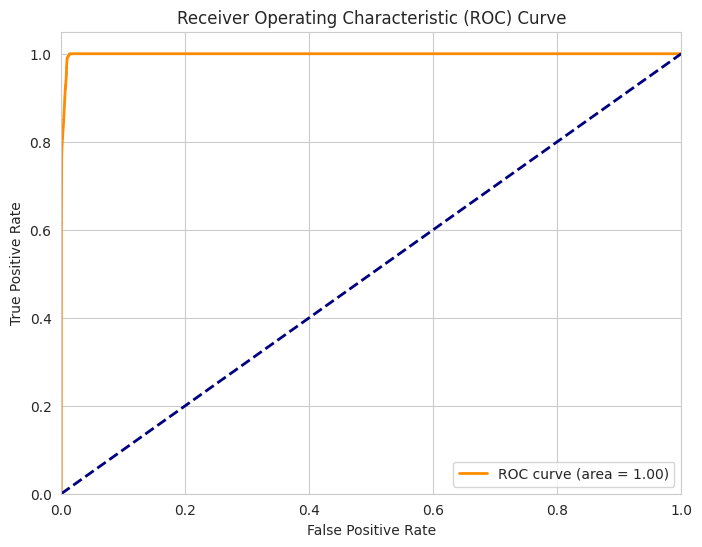

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, f1_score, precision_score, recall_score

#Calculate the FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, mae)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
autoencoder.save('/content/drive/My Drive/swat/model_autoencoder_SWaT_baseline.keras')
autoencoder.save('/content/drive/My Drive/swat/model_autoencoder_SWaT_baseline.h5')

In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/My Drive/swat/model_autoencoder_SWaT_baseline.keras'
autoencoder = load_model(model_path)

In [ ]:
roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
roc_data.to_csv('/content/drive/My Drive/ey_models/roc_curve_Autoencoder_SWaT_baseline.csv', index=False)

In [ ]:
thresholds = np.linspace(min(mae), max(mae), num=100)
precision_list, recall_list, f1_list = [], [], []

# Calculate precision, recall, and F1-score for each threshold
for threshold in thresholds:
    predicted_anomalies = (mae > threshold).astype(int)
    precision = precision_score(y_test, predicted_anomalies)
    recall = recall_score(y_test, predicted_anomalies)
    f1 = f1_score(y_test, predicted_anomalies)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import plotly.graph_objects as go
import numpy as np

# Create traces for Precision, Recall, and F1-score
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=thresholds,
    y=precision_list,
    mode='lines+markers',
    name='Precision',
    text=[f"Threshold: {x:.6f}, Precision: {y:.6f}" for x, y in zip(thresholds, precision_list)],
    hoverinfo='text',
    marker=dict(size=8)  # Increase marker size for easier hovering
))
fig.add_trace(go.Scatter(
    x=thresholds,
    y=recall_list,
    mode='lines+markers',
    name='Recall',
    text=[f"Threshold: {x:.6f}, Recall: {y:.6f}" for x, y in zip(thresholds, recall_list)],
    hoverinfo='text',
    marker=dict(size=8)
))
fig.add_trace(go.Scatter(
    x=thresholds,
    y=f1_list,
    mode='lines+markers',
    name='F1-score',
    text=[f"Threshold: {x:.6f}, F1-score: {y:.6f}" for x, y in zip(thresholds, f1_list)],
    hoverinfo='text',
    marker=dict(size=8)
))

# Set plot layout
fig.update_layout(
    title='Precision, Recall, and F1-score for Different Thresholds',
    xaxis_title='Threshold',
    yaxis_title='Score',
    legend_title='Metrics',
    hovermode='closest'
)

# Show the plot
fig.show()


# **AutoEncoder2**

In [ ]:
def create_autoencoder(inputs, dropoutrate=0.1, n_units=256, activation='sigmoid', optimizer='adam'):
    model = Sequential()
    model.add(Dense(units=n_units, activation=activation, input_dim=inputs))
    model.add(Dropout(dropoutrate))
    model.add(Dense(units=n_units // 4, activation=activation))
    model.add(Dense(units=inputs, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer,metrics=['accuracy'])
    return model

In [ ]:
autoencoder_last_16 = create_autoencoder(X_train.shape[1])

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
history_last = autoencoder_last_16.fit(
    X_train, X_train,
    epochs=50,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1116/1116 [==============================] - 6s 5ms/step - loss: 0.0241 - accuracy: 0.0834 - val_loss: 0.0034 - val_accuracy: 0.0499
Epoch 2/50
1116/1116 [==============================] - 5s 5ms/step - loss: 0.0033 - accuracy: 0.1407 - val_loss: 0.0019 - val_accuracy: 0.0867
Epoch 3/50
1116/1116 [==============================] - 5s 5ms/step - loss: 0.0022 - accuracy: 0.1490 - val_loss: 0.0013 - val_accuracy: 0.0804
Epoch 4/50
1116/1116 [==============================] - 6s 5ms/step - loss: 0.0016 - accuracy: 0.1543 - val_loss: 0.0010 - val_accuracy: 0.0225
Epoch 5/50
1116/1116 [==============================] - 5s 5ms/step - loss: 0.0013 - accuracy: 0.1658 - val_loss: 7.8913e-04 - val_accuracy: 0.0723
Epoch 6/50
1116/1116 [==============================] - 5s 5ms/step - loss: 0.0010 - accuracy: 0.1710 - val_loss: 5.8526e-04 - val_accuracy: 0.2089
Epoch 7/50
1116/1116 [==============================] - 5s 5ms/step - loss: 8.2039e-04 - accuracy: 0.1678 - val_loss: 4.1649e-04

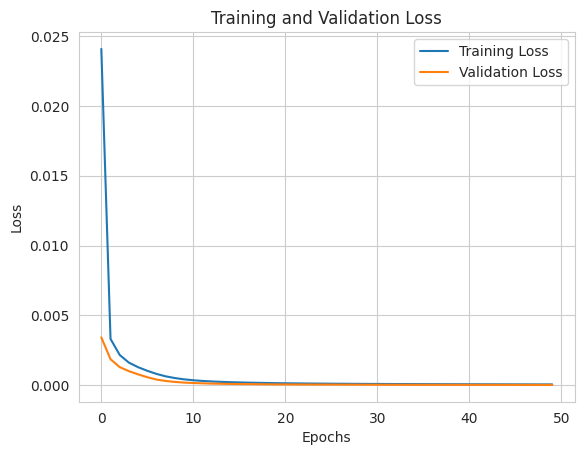

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_last.history['loss'], label='Training Loss')
plt.plot(history_last.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

11152/11152 [==============================] - 14s 1ms/step


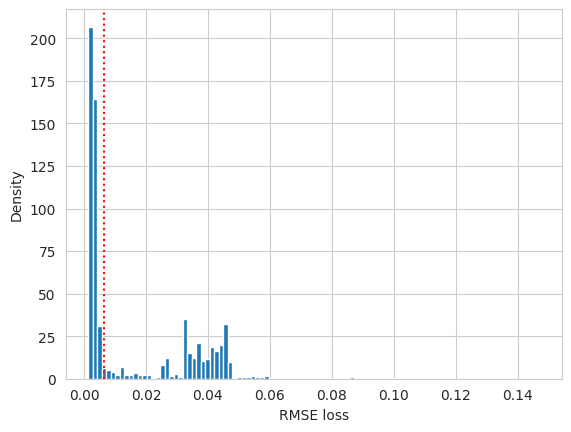

In [ ]:
X_test_predictions = autoencoder_last_16.predict(X_test)

mae = np.mean(np.abs(X_test_predictions - X_test), axis=1)
# Plot the histogram of RMSE loss
plt.hist(mae, bins=100, density=True)
plt.xlabel('RMSE loss')
plt.ylabel('Density')

# Visual determination of threshold - assuming you've determined it to be at RMSE = 0.25
# threshold = np.percentile(mae, 85)
threshold = 0.0065
plt.axvline(x=threshold, color='r', linestyle='dotted')

plt.show()

y_pred = (mae > threshold).astype(int)

In [ ]:
# Calculate the F1 Score, Precision, and Recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.8820341218266916
Precision: 0.9803624756842654
Recall: 0.8016320632662548


In [ ]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90    178293
           1       0.98      0.80      0.88    178547

    accuracy                           0.89    356840
   macro avg       0.91      0.89      0.89    356840
weighted avg       0.91      0.89      0.89    356840



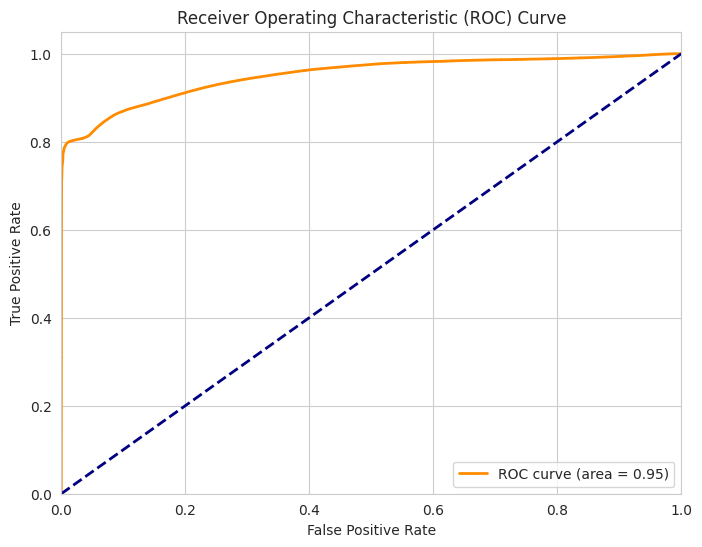

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, f1_score, precision_score, recall_score

#Calculate the FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, mae)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
thresholds = np.linspace(min(mae), max(mae), num=100)
precision_list, recall_list, f1_list = [], [], []

# Calculate precision, recall, and F1-score for each threshold
for threshold in thresholds:
    predicted_anomalies = (mae > threshold).astype(int)
    precision = precision_score(y_test, predicted_anomalies)
    recall = recall_score(y_test, predicted_anomalies)
    f1 = f1_score(y_test, predicted_anomalies)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Create traces for Precision, Recall, and F1-score
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=thresholds,
    y=precision_list,
    mode='lines+markers',
    name='Precision',
    text=[f"Threshold: {x:.6f}, Precision: {y:.6f}" for x, y in zip(thresholds, precision_list)],
    hoverinfo='text',
    marker=dict(size=8)  # Increase marker size for easier hovering
))
fig.add_trace(go.Scatter(
    x=thresholds,
    y=recall_list,
    mode='lines+markers',
    name='Recall',
    text=[f"Threshold: {x:.6f}, Recall: {y:.6f}" for x, y in zip(thresholds, recall_list)],
    hoverinfo='text',
    marker=dict(size=8)
))
fig.add_trace(go.Scatter(
    x=thresholds,
    y=f1_list,
    mode='lines+markers',
    name='F1-score',
    text=[f"Threshold: {x:.6f}, F1-score: {y:.6f}" for x, y in zip(thresholds, f1_list)],
    hoverinfo='text',
    marker=dict(size=8)
))

# Set plot layout
fig.update_layout(
    title='Precision, Recall, and F1-score for Different Thresholds',
    xaxis_title='Threshold',
    yaxis_title='Score',
    legend_title='Metrics',
    hovermode='closest'
)

# Show the plot
fig.show()


In [ ]:
autoencoder_last_16.save('/content/drive/My Drive/swat/model_autoencoder_SWaT_final.keras')
autoencoder_last_16.save('/content/drive/My Drive/swat/model_autoencoder_SWaT_final.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/swat/model_autoencoder_SWaT_final.h5'
autoencoder_last11 = load_model(model_path)